[0. 0. 1. 0. 0.]
[ 0.  0. -1. -1.  0.]
[0. 0. 0. 0. 0.]
[ 0. -1. -1.  0.  0.]
[0. 0. 0. 0. 0.]
Episode: 0
State    Up     Right    Down    Left
[0, 0] ['0.00', '0.00', '0.00', '0.00']
[0, 1] ['0.00', '0.00', '0.00', '0.00']
[0, 2] ['0.00', '0.00', '0.00', '0.00']
[0, 3] ['0.00', '0.00', '-0.90', '0.00']
[0, 4] ['0.00', '0.00', '0.00', '0.00']
[1, 0] ['0.00', '0.00', '0.00', '0.00']
[1, 1] ['0.00', '0.00', '0.00', '0.00']
[1, 2] ['0.00', '0.00', '0.00', '0.00']
[1, 3] ['0.00', '0.00', '0.00', '0.00']
[1, 4] ['0.00', '0.00', '0.00', '0.00']
[2, 0] ['0.00', '0.00', '0.00', '0.00']
[2, 1] ['0.00', '0.00', '0.00', '0.00']
[2, 2] ['0.00', '0.00', '0.00', '0.00']
[2, 3] ['0.00', '0.00', '0.00', '0.00']
[2, 4] ['0.00', '0.00', '0.00', '0.00']
[3, 0] ['0.00', '0.00', '0.00', '0.00']
[3, 1] ['0.00', '0.00', '0.00', '0.00']
[3, 2] ['0.00', '0.00', '0.00', '0.00']
[3, 3] ['0.00', '0.00', '0.00', '0.00']
[3, 4] ['0.00', '0.00', '0.00', '0.00']
[4, 0] ['0.00', '0.00', '0.00', '0.00']
[4, 1] ['0.00',

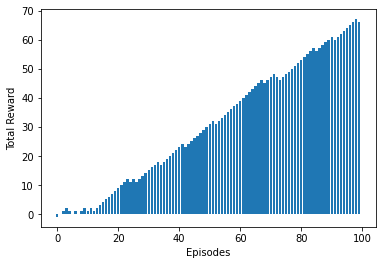

In [1]:
# -*- coding: utf-8 -*-
"""Q-Learning Assign_1.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1J_u-LplrhKpc1DG_nbmNSxA-LLTetDqK

## Scenario - Robot in a 5X5 grid
In a 5X5 grid environment, robots search for the path to reach the charging dock area from given position i.e. [4,2] or wherever it is in 10 steps.

In order to ensure maximum efficiency the robots will need to learn the shortest path between the chargin dock area and all other locations within the grid where the robots are allowed to travel.
* We will use Q-learning to accomplish this task!
"""

#import libraries
import numpy as np
import matplotlib.pyplot as plt

"""## Define the Environment
The environment consists of **states**, **actions**, and **rewards**. States and actions are inputs for the Q-learning AI agent, while the possible actions are the AI agent's outputs.
#### States
The states in the environment are all of the possible locations within the grid. Some of these locations are inaccessible (**gray squares**), while other locations are aisles that the robot can use to travel throughout the grid (**white squares**). The **charging dock area is in yellow cell** indicates the charging dock area.

The gray squares are **terminal states**!

![picture](https://drive.google.com/uc?export=view&id=1Jdu7axfpNn0EzV2oiENcIxo7ghiLEjf9)

The AI agent's goal is to learn the shortest path between the charging dock area and all of the other locations in the grid where the robot is allowed to travel.

As shown in the image above, there are 25 possible states (locations) within the grid. These states are arranged in a grid containing 5 rows and 5 columns. Each location can hence be identified by its row and column index.
"""

#define the shape of the environment (i.e., its states)
environment_rows = 5
environment_columns = 5

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 5 rows and 5 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4))

"""#### Actions
The actions that are available to the AI agent are to move the robot in one of four directions:
* Up
* Right
* Down
* Left

Obviously, the AI agent must learn to avoid driving into the inaccessible locations!

"""

#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

"""#### Rewards
The last component of the environment that we need to define are the **rewards**. 

To help the AI agent learn, each state (location) in the grid is assigned a reward value.

The agent may begin at any white square, but its goal is always the same: ***to maximize its total rewards***!

To maximize its cumulative rewards , the AI agent will need find the shortest paths between the charging dock area (yellow square) and all of the other locations in the grid where the robot is allowed to travel (white squares). The agent will also need to learn to avoid crashing into any of the inaccessible areas (black squares)!
"""

#Create a 2D numpy array to hold the rewards for each state. 
#The array contains 5 rows and 5 columns (to match the shape of the environment), and each value is initialized to 0.
rewards = np.full((environment_rows, environment_columns), 0.)
rewards[0, 2] = 1. #set the reward for the charging dock area (i.e., the goal) to 1

#define inaccessible locations (i.e., black squares) for rows 1 through 5
inacc = {} #inaccessible locations in a dictionary
inacc[1] = [2, 3]
inacc[3] = [1, 2]

#set the rewards for all inaccessible locations (i.e., black squares)
for row_index in [1,3]:
  for column_index in inacc[row_index]:
    rewards[row_index, column_index] = -1
  
# print rewards matrix
for row in rewards:
  print(row)

"""## Train the Model
Our next task is for our AI agent to learn about its environment by implementing a Q-learning model. The learning process will follow these steps:
1. Choose a random, non-terminal state (white square) for the agent to begin this new episode.
2. Choose an action (move *up*, *right*, *down*, or *left*) for the current state. Actions will be chosen using an *epsilon greedy algorithm*. This algorithm will usually choose the most promising action for the AI agent, but it will occasionally choose a less promising option in order to encourage the agent to explore the environment.
3. Perform the chosen action, and transition to the next state (i.e., move to the next location).
4. Receive the reward for moving to the new state, and calculate the temporal difference.
5. Update the Q-value for the previous state and action pair.
6. If the new (current) state is a terminal state, go to #1. Else, go to #2.

This entire process will be repeated across 1000 episodes. This will provide the AI agent sufficient opportunity to learn the shortest paths between the charging dock area and all other locations in the grid where the robot is allowed to travel, while simultaneously avoiding crashing into any of the inaccessible locations!

#### Define Helper Functions
"""

#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is 0, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == 0.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon, 
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#define a function that will get the shortest path between any location within the grid that 
#the robot is allowed to travel and the charging dock location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the charging dock location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

"""#### Train the AI Agent using Q-Learning"""

#define training parameters
epsilon = 0.8 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn
episodes = 100 #number of training episodes

#initialize reward for each location for each episode to zero
rewards_x = np.zeros(episodes)

#run through 100 training episodes
for episode in range(episodes):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()
  #row_index, column_index = 4, 2

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the charging dock area or crash into an inaccessible location)
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)
    
    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update rewards of each episode for each location
    rewards_x[episode] = reward

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

  if episode == 0 or (episode == 1 or (episode == 10 or episode == episodes-1)):
    print('Episode: %d' % episode)
    print('State    Up     Right    Down    Left')
    for i in range(5):
      for j in range(5):
        formatted_q_values = ['%.2f' % member for member in q_values[i,j]]
        #print(q_values[4,2])
        print('[%d, %d]' %(i,j), formatted_q_values)

print('Training complete!')
rewards_tot = np.cumsum(rewards_x)
plt.bar(range(episodes),rewards_tot)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')

"""## Get Shortest Paths
Now that the AI agent has been fully trained, we can see what it has learned by displaying the shortest path between any location in the grid where the robot is allowed to travel and the charging dock area.

Run the code cell below to try a few different starting locations!
"""

#display a few shortest paths
print(get_shortest_path(4, 2)) #starting at row 9, column 5
print(get_shortest_path(3, 4)) #starting at row 3, column 9
print(get_shortest_path(3, 0)) #starting at row 5, column 0

# SARSA

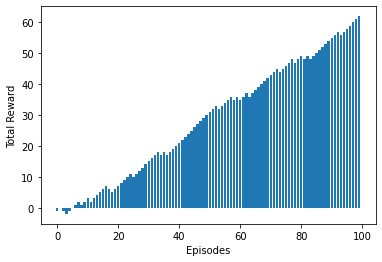

[[4, 2], [4, 3], [3, 3], [3, 4], [2, 4], [1, 4], [0, 4], [0, 3], [0, 2]]
[[3, 4], [2, 4], [1, 4], [0, 4], [0, 3], [0, 2]]
[[3, 0], [2, 0], [1, 0], [0, 0], [0, 1], [0, 2]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the environment
environment_rows = 5
environment_columns = 5

# Initialize Q-values
q_values = np.zeros((environment_rows, environment_columns, 4))

# Define actions
actions = ['up', 'right', 'down', 'left']

# Initialize rewards
rewards = np.full((environment_rows, environment_columns), 0.)
rewards[0, 2] = 1.  # Charging dock area reward

# Define inaccessible locations
inacc = {1: [2, 3], 3: [1, 2]}
for row_index in [1, 3]:
    for column_index in inacc[row_index]:
        rewards[row_index, column_index] = -1

# Helper functions
def is_terminal_state(current_row_index, current_column_index):
    return rewards[current_row_index, current_column_index] != 0.

def get_starting_location():
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = np.random.randint(environment_rows)
        current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

def get_next_action(current_row_index, current_column_index, epsilon):
    if np.random.random() < epsilon:
        return np.argmax(q_values[current_row_index, current_column_index])
    else:
        return np.random.randint(4)

def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    return new_row_index, new_column_index

def get_shortest_path(start_row_index, start_column_index):
    if is_terminal_state(start_row_index, start_column_index):
        return []
    else:
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])
        while not is_terminal_state(current_row_index, current_column_index):
            action_index = get_next_action(current_row_index, current_column_index, 1.)
            current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
            shortest_path.append([current_row_index, current_column_index])
        return shortest_path

# SARSA parameters
epsilon = 0.8
discount_factor = 0.9
learning_rate = 0.9
episodes = 100

# Initialize rewards for each episode
rewards_x = np.zeros(episodes)

# SARSA training
for episode in range(episodes):
    row_index, column_index = get_starting_location()
    action_index = get_next_action(row_index, column_index, epsilon)

    while not is_terminal_state(row_index, column_index):
        old_row_index, old_column_index = row_index, column_index
        old_action_index = action_index
        
        row_index, column_index = get_next_location(row_index, column_index, action_index)
        reward = rewards[row_index, column_index]
        rewards_x[episode] += reward
        
        next_action_index = get_next_action(row_index, column_index, epsilon)

        old_q_value = q_values[old_row_index, old_column_index, old_action_index]
        next_q_value = q_values[row_index, column_index, next_action_index]
        temporal_difference = reward + (discount_factor * next_q_value) - old_q_value
        
        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_row_index, old_column_index, old_action_index] = new_q_value

        action_index = next_action_index

# Plotting the total rewards
rewards_tot = np.cumsum(rewards_x)
plt.bar(range(episodes), rewards_tot)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

# Display a few shortest paths
print(get_shortest_path(4, 2))
print(get_shortest_path(3, 4))
print(get_shortest_path(3, 0))